In [34]:
# ============================================================
# IDRiD MULTI-LESION SEGMENTATION (APPLE M-SERIES SAFE)
# ============================================================

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as imageio
from tqdm import tqdm

# ============================
# CONFIG
# ============================
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
IMG_SIZE = 512
ROOT = "/Users/akhilgattu/Desktop/VLM_project"
OUT_DIR = "./visual_results"
os.makedirs(OUT_DIR, exist_ok=True)

LESIONS = [
    "Microaneurysms",
    "Haemorrhages",
    "HardExudates",
    "SoftExudates",
    "OpticDisc"
]

COLORS = {
    "Microaneurysms": (255, 0, 0),
    "Haemorrhages": (0, 0, 255),
    "HardExudates": (255, 255, 0),
    "SoftExudates": (0, 255, 255),
    "OpticDisc": (0, 255, 0)
}

THRESHOLDS = {
    "Microaneurysms": 0.2,
    "Haemorrhages": 0.3,
    "HardExudates": 0.4,
    "SoftExudates": 0.4,
    "OpticDisc": 0.5
}

LESION_FOLDERS = {
    "Microaneurysms": "1. Microaneurysms",
    "Haemorrhages": "2. Haemorrhages",
    "HardExudates": "3. Hard Exudates",
    "SoftExudates": "4. Soft Exudates",
    "OpticDisc": "5. Optic Disc"
}

SUFFIX_MAP = {
    "Microaneurysms": "_MA.tif",
    "Haemorrhages": "_HE.tif",
    "HardExudates": "_EX.tif",
    "SoftExudates": "_SE.tif",
    "OpticDisc": "_OD.tif"
}

# ============================
# DATASET
# ============================
class IDRiDSegmentationDataset(Dataset):
    def __init__(self, root, split="train"):
        if split == "train":
            self.image_dir = os.path.join(root, "A. Segmentation", "1. Original Images", "a. Training Set")
            self.mask_root = os.path.join(root, "A. Segmentation", "2. All Segmentation Groundtruths", "a. Training Set")
        else:
            self.image_dir = os.path.join(root, "A. Segmentation", "1. Original Images", "b. Testing Set")
            self.mask_root = os.path.join(root, "A. Segmentation", "2. All Segmentation Groundtruths", "b. Testing Set")

        self.images = sorted(os.listdir(self.image_dir))

    def __len__(self):
        return len(self.images)

    def _load_mask(self, path):
        if not os.path.exists(path):
            return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        m = imageio.imread(path)

        # 🔑 FIX: convert bool → uint8
        if m.dtype == np.bool_:
            m = m.astype(np.uint8) * 255

        m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        return (m > 0).astype(np.float32)


    def __getitem__(self, idx):
        name = self.images[idx]
        base = name.replace(".jpg", "")

        img = cv2.imread(os.path.join(self.image_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        img_t = torch.tensor(img).permute(2, 0, 1).float()

        masks = []
        for lesion in LESIONS:
            path = os.path.join(
                self.mask_root,
                LESION_FOLDERS[lesion],
                base + SUFFIX_MAP[lesion]
            )
            masks.append(self._load_mask(path))

        masks = torch.tensor(np.stack(masks)).float()
        return img_t, masks, img, name

# ============================
# MODEL (UNET)
# ============================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)

        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

# ============================
# LOSS
# ============================
def dice_loss_multilabel(logits, targets):
    probs = torch.sigmoid(logits)
    loss, valid = 0.0, 0

    for c in range(probs.shape[1]):
        t = targets[:, c]
        if t.sum() == 0:
            continue
        p = probs[:, c]
        intersection = (p * t).sum()
        union = p.sum() + t.sum() + 1e-6
        loss += 1 - (2 * intersection / union)
        valid += 1

    return loss / max(valid, 1)

# ============================
# METRICS
# ============================
def dice_scores(logits, targets):
    probs = torch.sigmoid(logits)
    results = {}

    for i, lesion in enumerate(LESIONS):
        t = targets[:, i]
        if t.sum() == 0:
            continue
        p = (probs[:, i] > THRESHOLDS[lesion]).float()
        dice = (2 * (p * t).sum()) / (p.sum() + t.sum() + 1e-6)
        results[lesion] = dice.item()

    return results

def foreground_accuracy(logits, targets):
    probs = torch.sigmoid(logits)
    pred_fg = torch.zeros_like(targets[:, 0])
    gt_fg = torch.zeros_like(targets[:, 0])

    for i, lesion in enumerate(LESIONS):
        pred_fg |= (probs[:, i] > THRESHOLDS[lesion])
        gt_fg |= (targets[:, i] > 0)

    return (pred_fg == gt_fg).float().mean().item()

# ============================
# TRAINING
# ============================
def train(model, loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    bce = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        total = 0.0

        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            imgs, masks = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = 0.7 * bce(logits, masks) + 0.3 * dice_loss_multilabel(logits, masks)
            loss.backward()
            optimizer.step()
            total += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total/len(loader):.4f}")

# ============================
# VISUALIZATION
# ============================
def overlay(image, pred_masks):
    out = image.copy()
    for i, lesion in enumerate(LESIONS):
        mask = pred_masks[i]
        out[mask > 0] = 0.6 * out[mask > 0] + 0.4 * np.array(COLORS[lesion])
    return out.astype(np.uint8)

def visualize(model, dataset, n=5):
    model.eval()
    for i in range(n):
        img_t, masks, img_np, name = dataset[i]
        with torch.no_grad():
            logits = model(img_t.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(logits)[0].cpu()

        pred = np.zeros_like(probs.numpy())
        for j, lesion in enumerate(LESIONS):
            pred[j] = (probs[j] > THRESHOLDS[lesion]).numpy()

        vis = overlay((img_np * 255).astype(np.uint8), pred)
        cv2.imwrite(os.path.join(OUT_DIR, name), cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

# ============================
# MAIN
# ============================
if __name__ == "__main__":
    train_ds = IDRiDSegmentationDataset(ROOT, "train")
    test_ds = IDRiDSegmentationDataset(ROOT, "test")

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
    model = UNet(n_classes=5).to(DEVICE)

    train(model, train_loader, epochs=50)
    visualize(model, test_ds)
    torch.save({"model_state_dict": model.state_dict()}, "unet_idrids.pth")

Epoch 1:   0%|          | 0/27 [00:00<?, ?it/s]/var/folders/61/80bh8zbs3rg_9w2k2zqhghd00000gn/T/ipykernel_1493/4086962817.py:88: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = m.astype(np.uint8) * 255
Epoch 1: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 1 | Loss: 0.7170


Epoch 2: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 2 | Loss: 0.6503


Epoch 3: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 3 | Loss: 0.6279


Epoch 4: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 4 | Loss: 0.6112


Epoch 5: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


Epoch 5 | Loss: 0.5949


Epoch 6: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 6 | Loss: 0.5783


Epoch 7: 100%|██████████| 27/27 [01:55<00:00,  4.27s/it]


Epoch 7 | Loss: 0.5649


Epoch 8: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 8 | Loss: 0.5493


Epoch 9: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


Epoch 9 | Loss: 0.5358


Epoch 10: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 10 | Loss: 0.5238


Epoch 11: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 11 | Loss: 0.5107


Epoch 12: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


Epoch 12 | Loss: 0.4998


Epoch 13: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 13 | Loss: 0.4889


Epoch 14: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 14 | Loss: 0.4786


Epoch 15: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 15 | Loss: 0.4679


Epoch 16: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 16 | Loss: 0.4574


Epoch 17: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 17 | Loss: 0.4482


Epoch 18: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 18 | Loss: 0.4394


Epoch 19: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 19 | Loss: 0.4310


Epoch 20: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 20 | Loss: 0.4223


Epoch 21: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 21 | Loss: 0.4147


Epoch 22: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 22 | Loss: 0.4077


Epoch 23: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 23 | Loss: 0.4005


Epoch 24: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 24 | Loss: 0.3939


Epoch 25: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 25 | Loss: 0.3890


Epoch 26: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 26 | Loss: 0.3840


Epoch 27: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 27 | Loss: 0.3781


Epoch 28: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 28 | Loss: 0.3716


Epoch 29: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 29 | Loss: 0.3657


Epoch 30: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 30 | Loss: 0.3606


Epoch 31: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 31 | Loss: 0.3555


Epoch 32: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 32 | Loss: 0.3505


Epoch 33: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 33 | Loss: 0.3454


Epoch 34: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 34 | Loss: 0.3411


Epoch 35: 100%|██████████| 27/27 [01:42<00:00,  3.80s/it]


Epoch 35 | Loss: 0.3366


Epoch 36: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 36 | Loss: 0.3329


Epoch 37: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 37 | Loss: 0.3284


Epoch 38: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 38 | Loss: 0.3238


Epoch 39: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 39 | Loss: 0.3218


Epoch 40: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 40 | Loss: 0.3144


Epoch 41: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 41 | Loss: 0.3116


Epoch 42: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]


Epoch 42 | Loss: 0.3065


Epoch 43: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]


Epoch 43 | Loss: 0.3047


Epoch 44: 100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch 44 | Loss: 0.2998


Epoch 45: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 45 | Loss: 0.2963


Epoch 46: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 46 | Loss: 0.2927


Epoch 47: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 47 | Loss: 0.2899


Epoch 48: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]


Epoch 48 | Loss: 0.2864


Epoch 49: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 49 | Loss: 0.2819


Epoch 50: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]


Epoch 50 | Loss: 0.2824


In [7]:
torch.save({
    "model_state_dict": model.state_dict()}, "unet_idrids.pth")

In [35]:
visualize(model, test_ds)

/var/folders/61/80bh8zbs3rg_9w2k2zqhghd00000gn/T/ipykernel_1493/4086962817.py:88: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = m.astype(np.uint8) * 255


In [ ]:
import torch
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    """
    pred: (B, C, H, W) – raw logits or probabilities
    target: (B, H, W) – class indices
    """
    pred = F.softmax(pred, dim=1)
    num_classes = pred.shape[1]

    target_onehot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(pred * target_onehot, dims)
    union = torch.sum(pred + target_onehot, dims)

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()



(tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0

In [20]:
DEVICE = "mps" if torch.cuda.is_available() else "cpu"

model = UNet(n_classes=5).to(DEVICE)
checkpoint = torch.load("unet_idrids.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


UNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (net): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3,

In [21]:
from torch.utils.data import DataLoader

test_dataset = IDRiDSegmentationDataset(
    root=ROOT,
    split="test"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True  # ensures a different image
)


batch = next(iter(test_loader))
image = batch[0].to(DEVICE)
mask = batch[1].to(DEVICE)
print(batch[3])


('IDRiD_75.jpg',)


In [28]:
import torch

def dice_loss_onehot(pred, target, smooth=1e-6):
    """
    pred   : (B, C, H, W) logits
    target : (B, C, H, W) one-hot mask
    """
    pred = torch.softmax(pred, dim=1)
    target = target.float()

    dims = (0, 2, 3)
    intersection = torch.sum(pred * target, dims)
    union = torch.sum(pred + target, dims)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1. - dice.mean()


In [27]:
print(mask.shape, image.shape)

torch.Size([1, 5, 512, 512]) torch.Size([1, 3, 512, 512])


In [29]:
img_id = batch[3][0]
with torch.no_grad():
    pred = model(image)
    loss = dice_loss_onehot(pred, mask.long())

print(f"Test Image ID: {img_id}")
print(f"Dice Loss: {loss.item():.4f}")

Test Image ID: IDRiD_75.jpg
Dice Loss: 0.9477


In [31]:
def per_class_dice(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = target.float()

    dices = []
    for c in range(pred.shape[1]):
        p = pred[:, c]
        t = target[:, c]
        intersection = (p * t).sum()
        union = p.sum() + t.sum()
        dice = (2 * intersection + smooth) / (union + smooth)
        dices.append(dice.item())

    return dices

scores = per_class_dice(pred, mask)

for i, d in enumerate(scores):
    print(f"Class {i} Dice: {d:.4f}")


Class 0 Dice: 0.0038
Class 1 Dice: 0.0407
Class 2 Dice: 0.0081
Class 3 Dice: 0.0051
Class 4 Dice: 0.2036


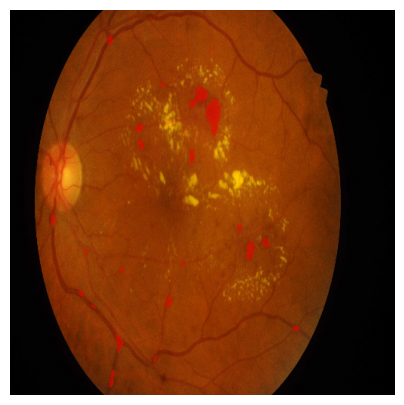

In [40]:
lesion = "Haemorrhages"
i = LESIONS.index(lesion)

overlay_mask(
    img,
    gt[i].numpy(),
    (pred[i] > 0.5).numpy()
)


In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50

# =========================================================
# CONFIG
# =========================================================

NUM_CLASSES = 6
IMAGE_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 30
FREEZE_EPOCHS = 5

LR_BACKBONE = 1e-5
LR_CLASSIFIER = 1e-4

CLASS_WEIGHTS = torch.tensor(
    [0.02,   # background (very low)
     8.0,    # microaneurysms
     6.0,    # hemorrhages
     4.0,    # hard exudates
     4.0,    # soft exudates
     2.0],   # optic disc
    device='mps' if torch.backends.mps.is_available() else 'cpu'
)


SAVE_EVERY = 5
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

CLASS_NAMES = [
    "Background",
    "Microaneurysms",
    "Hemorrhages",
    "Hard Exudates",
    "Soft Exudates",
    "Optic Disc",
]

LESION_FOLDERS = {
    "1. Microaneurysms": 1,
    "2. Haemorrhages": 2,
    "3. Hard Exudates": 3,
    "4. Soft Exudates": 4,
    "5. Optic Disc": 5,
}

# =========================================================
# DEVICE
# =========================================================

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# =========================================================
# DATASET
# =========================================================

class IDRiDSegmentationDataset(Dataset):
    def __init__(self, root, split="train"):
        if split == "train":
            self.image_dir = os.path.join(
                root, "A. Segmentation", "1. Original Images", "a. Training Set"
            )
            self.mask_root = os.path.join(
                root, "A. Segmentation", "2. All Segmentation Groundtruths", "a. Training Set"
            )
        else:
            self.image_dir = os.path.join(
                root, "A. Segmentation", "1. Original Images", "b. Testing Set"
            )
            self.mask_root = os.path.join(
                root, "A. Segmentation", "2. All Segmentation Groundtruths", "b. Testing Set"
            )

        self.images = sorted(os.listdir(self.image_dir))

        self.img_transform = T.Compose([
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

        self.mask_resize = T.Resize(
            (IMAGE_SIZE, IMAGE_SIZE),
            interpolation=T.InterpolationMode.NEAREST
        )

        # lesion → (folder, suffix)
        self.lesion_map = {
            1: ("1. Microaneurysms", "_MA.tif"),
            2: ("2. Haemorrhages", "_HE.tif"),
            3: ("3. Hard Exudates", "_EX.tif"),
            4: ("4. Soft Exudates", "_SE.tif"),
            5: ("5. Optic Disc", "_OD.tif"),
        }

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_id = os.path.splitext(img_name)[0]  # IDRiD_01

        # ---- image ----
        image = Image.open(
            os.path.join(self.image_dir, img_name)
        ).convert("RGB")
        image = self.img_transform(image)

        # ---- merged mask ----
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

        for cls_id, (folder, suffix) in self.lesion_map.items():
            mask_name = img_id + suffix
            mask_path = os.path.join(self.mask_root, folder, mask_name)

            if os.path.exists(mask_path):
                lesion = Image.open(mask_path).convert("L")
                lesion = self.mask_resize(lesion)
                lesion = np.array(lesion)

                mask[lesion > 0] = cls_id

        return image, torch.from_numpy(mask).long()


# =========================================================
# MODEL
# =========================================================

def get_model():
    model = deeplabv3_resnet50(weights="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, 1)
    return model

def freeze_backbone(model):
    for p in model.backbone.parameters():
        p.requires_grad = False

def unfreeze_backbone(model):
    for p in model.backbone.parameters():
        p.requires_grad = True

# =========================================================
# LOSSES
# =========================================================

class DiceLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        targets_oh = torch.nn.functional.one_hot(
            targets, NUM_CLASSES
        ).permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        inter = (probs * targets_oh).sum(dims)
        union = probs.sum(dims) + targets_oh.sum(dims)

        dice = (2 * inter + 1.0) / (union + 1.0)
        return 1 - dice.mean()


class WeightedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(
            logits,
            targets,
            weight=CLASS_WEIGHTS,
            reduction="none"
        )
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

# =========================================================
# METRICS
# =========================================================

@torch.no_grad()
def dice_per_class(logits, targets):
    preds = torch.argmax(logits, dim=1)
    dices = []

    for cls in range(1, NUM_CLASSES):
        p = (preds == cls).float()
        t = (targets == cls).float()

        inter = (p * t).sum()
        union = p.sum() + t.sum()

        dices.append(
            (2 * inter / union) if union > 0
            else torch.tensor(1.0, device=logits.device)
        )

    return torch.stack(dices)

# =========================================================
# TRAIN / VALIDATE
# =========================================================

def train_epoch(model, loader, optimizer, dice_loss, focal_loss):
    model.train()
    total_loss = 0.0

    for imgs, masks in tqdm(loader, leave=False):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        out = model(imgs)["out"]

        loss = dice_loss(out, masks) + focal_loss(out, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader):
    model.eval()
    scores = torch.zeros(NUM_CLASSES - 1, device=device)

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(imgs)["out"]
        scores += dice_per_class(out, masks)

    return scores / len(loader)

# =========================================================
# CHECKPOINTING
# =========================================================

def save_checkpoint(model, optimizer, epoch, phase):
    path = os.path.join(
        CHECKPOINT_DIR,
        f"deeplabv3_idrid_epoch_{epoch:03d}_{phase}.pth"
    )
    torch.save(
        {
            "epoch": epoch,
            "phase": phase,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path
    )
    print(f"Saved checkpoint: {path}")

# =========================================================
# MAIN
# =========================================================

def main():
    root = "/Users/akhilgattu/Desktop/VLM_project"  # CHANGE IF NEEDED

    train_ds = IDRiDSegmentationDataset(root, "train")
    val_ds = IDRiDSegmentationDataset(root, "test")

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

    model = get_model().to(device)

    dice_loss = DiceLoss()
    focal_loss = WeightedFocalLoss()

    # ------------------ PHASE 1 ------------------
    print("Phase 1: Training classifier head only")
    freeze_backbone(model)

    optimizer = optim.AdamW(
        model.classifier.parameters(),
        lr=LR_CLASSIFIER,
        weight_decay=1e-4
    )

    for epoch in range(FREEZE_EPOCHS):
        loss = train_epoch(model, train_loader, optimizer, dice_loss, focal_loss)
        print(f"Epoch {epoch+1}/{FREEZE_EPOCHS} | Loss: {loss:.4f}")

        if (epoch + 1) % SAVE_EVERY == 0:
            save_checkpoint(model, optimizer, epoch + 1, phase="frozen")

    # ------------------ PHASE 2 ------------------
    print("Phase 2: Fine-tuning full network")
    unfreeze_backbone(model)

    optimizer = optim.AdamW(
        [
            {"params": model.backbone.parameters(), "lr": LR_BACKBONE},
            {"params": model.classifier.parameters(), "lr": LR_CLASSIFIER},
        ],
        weight_decay=1e-4
    )

    for epoch in range(FREEZE_EPOCHS, EPOCHS):
        loss = train_epoch(model, train_loader, optimizer, dice_loss, focal_loss)
        dice = validate(model, val_loader)

        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        for i, d in enumerate(dice):
            print(f"{CLASS_NAMES[i+1]} Dice: {d.item():.4f}")
        print(f"Mean Dice: {dice.mean().item():.4f}")

        if (epoch + 1) % SAVE_EVERY == 0:
            save_checkpoint(model, optimizer, epoch + 1, phase="finetune")

    torch.save(model.state_dict(), "deeplabv3_idrid_finetuned.pth")
    print("Final model saved: deeplabv3_idrid_finetuned.pth")

if __name__ == "__main__":
    main()


Using device: mps
Phase 1: Training classifier head only


Epoch 1/5 | Loss: 1.1235


Epoch 2/5 | Loss: 1.0432


Epoch 3/5 | Loss: 0.9841


Epoch 4/5 | Loss: 0.9416


Epoch 5/5 | Loss: 0.9152
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_005_frozen.pth
Phase 2: Fine-tuning full network



Epoch 6/30
Microaneurysms Dice: 0.0018
Hemorrhages Dice: 0.0478
Hard Exudates Dice: 0.1009
Soft Exudates Dice: 0.1429
Optic Disc Dice: 0.6369
Mean Dice: 0.1861



Epoch 7/30
Microaneurysms Dice: 0.0018
Hemorrhages Dice: 0.0448
Hard Exudates Dice: 0.1476
Soft Exudates Dice: 0.0335
Optic Disc Dice: 0.7158
Mean Dice: 0.1887



Epoch 8/30
Microaneurysms Dice: 0.0024
Hemorrhages Dice: 0.0607
Hard Exudates Dice: 0.1424
Soft Exudates Dice: 0.0687
Optic Disc Dice: 0.6977
Mean Dice: 0.1944



Epoch 9/30
Microaneurysms Dice: 0.0019
Hemorrhages Dice: 0.0449
Hard Exudates Dice: 0.1892
Soft Exudates Dice: 0.0872
Optic Disc Dice: 0.7665
Mean Dice: 0.2179



Epoch 10/30
Microaneurysms Dice: 0.0031
Hemorrhages Dice: 0.0660
Hard Exudates Dice: 0.1790
Soft Exudates Dice: 0.0938
Optic Disc Dice: 0.7903
Mean Dice: 0.2264
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_010_finetune.pth



Epoch 11/30
Microaneurysms Dice: 0.0028
Hemorrhages Dice: 0.0725
Hard Exudates Dice: 0.1991
Soft Exudates Dice: 0.1147
Optic Disc Dice: 0.7937
Mean Dice: 0.2366



Epoch 12/30
Microaneurysms Dice: 0.0027
Hemorrhages Dice: 0.0612
Hard Exudates Dice: 0.2322
Soft Exudates Dice: 0.1251
Optic Disc Dice: 0.8152
Mean Dice: 0.2473



Epoch 13/30
Microaneurysms Dice: 0.0033
Hemorrhages Dice: 0.0995
Hard Exudates Dice: 0.1811
Soft Exudates Dice: 0.1121
Optic Disc Dice: 0.8753
Mean Dice: 0.2542



Epoch 14/30
Microaneurysms Dice: 0.0031
Hemorrhages Dice: 0.0867
Hard Exudates Dice: 0.2168
Soft Exudates Dice: 0.1684
Optic Disc Dice: 0.8824
Mean Dice: 0.2715



Epoch 15/30
Microaneurysms Dice: 0.0035
Hemorrhages Dice: 0.1157
Hard Exudates Dice: 0.2243
Soft Exudates Dice: 0.1667
Optic Disc Dice: 0.9043
Mean Dice: 0.2829
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_015_finetune.pth



Epoch 16/30
Microaneurysms Dice: 0.0033
Hemorrhages Dice: 0.1083
Hard Exudates Dice: 0.2555
Soft Exudates Dice: 0.1595
Optic Disc Dice: 0.9032
Mean Dice: 0.2860



Epoch 17/30
Microaneurysms Dice: 0.0037
Hemorrhages Dice: 0.1673
Hard Exudates Dice: 0.2949
Soft Exudates Dice: 0.2294
Optic Disc Dice: 0.9051
Mean Dice: 0.3201



Epoch 18/30
Microaneurysms Dice: 0.0037
Hemorrhages Dice: 0.1822
Hard Exudates Dice: 0.3119
Soft Exudates Dice: 0.2558
Optic Disc Dice: 0.9125
Mean Dice: 0.3332



Epoch 19/30
Microaneurysms Dice: 0.0036
Hemorrhages Dice: 0.1849
Hard Exudates Dice: 0.2456
Soft Exudates Dice: 0.2410
Optic Disc Dice: 0.9170
Mean Dice: 0.3184



Epoch 20/30
Microaneurysms Dice: 0.0038
Hemorrhages Dice: 0.2262
Hard Exudates Dice: 0.3455
Soft Exudates Dice: 0.3117
Optic Disc Dice: 0.9207
Mean Dice: 0.3616
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_020_finetune.pth



Epoch 21/30
Microaneurysms Dice: 0.0039
Hemorrhages Dice: 0.2001
Hard Exudates Dice: 0.3269
Soft Exudates Dice: 0.2987
Optic Disc Dice: 0.9205
Mean Dice: 0.3500



Epoch 22/30
Microaneurysms Dice: 0.0038
Hemorrhages Dice: 0.2443
Hard Exudates Dice: 0.2888
Soft Exudates Dice: 0.3460
Optic Disc Dice: 0.9117
Mean Dice: 0.3589



Epoch 23/30
Microaneurysms Dice: 0.0041
Hemorrhages Dice: 0.2564
Hard Exudates Dice: 0.2915
Soft Exudates Dice: 0.3299
Optic Disc Dice: 0.9214
Mean Dice: 0.3606



Epoch 24/30
Microaneurysms Dice: 0.0042
Hemorrhages Dice: 0.3258
Hard Exudates Dice: 0.3895
Soft Exudates Dice: 0.3346
Optic Disc Dice: 0.9261
Mean Dice: 0.3960



Epoch 25/30
Microaneurysms Dice: 0.0041
Hemorrhages Dice: 0.3308
Hard Exudates Dice: 0.3115
Soft Exudates Dice: 0.3620
Optic Disc Dice: 0.9289
Mean Dice: 0.3875
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_025_finetune.pth



Epoch 26/30
Microaneurysms Dice: 0.0039
Hemorrhages Dice: 0.3007
Hard Exudates Dice: 0.3835
Soft Exudates Dice: 0.3629
Optic Disc Dice: 0.9300
Mean Dice: 0.3962



Epoch 27/30
Microaneurysms Dice: 0.0039
Hemorrhages Dice: 0.3091
Hard Exudates Dice: 0.3302
Soft Exudates Dice: 0.3457
Optic Disc Dice: 0.9337
Mean Dice: 0.3845



Epoch 28/30
Microaneurysms Dice: 0.0043
Hemorrhages Dice: 0.3941
Hard Exudates Dice: 0.4205
Soft Exudates Dice: 0.2891
Optic Disc Dice: 0.9312
Mean Dice: 0.4078



Epoch 29/30
Microaneurysms Dice: 0.0041
Hemorrhages Dice: 0.2974
Hard Exudates Dice: 0.3541
Soft Exudates Dice: 0.3695
Optic Disc Dice: 0.9353
Mean Dice: 0.3921



Epoch 30/30
Microaneurysms Dice: 0.0042
Hemorrhages Dice: 0.3725
Hard Exudates Dice: 0.4117
Soft Exudates Dice: 0.3880
Optic Disc Dice: 0.9379
Mean Dice: 0.4229
Saved checkpoint: checkpoints/deeplabv3_idrid_epoch_030_finetune.pth
Final model saved: deeplabv3_idrid_finetuned.pth


In [1]:
!pwd

/Users/akhilgattu/Desktop/VLM_project


In [21]:
input_tensor = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
with torch.no_grad():
    logits = model(input_tensor)["out"][0]
    probs = torch.softmax(logits, dim=0)

print("Max prob per class:", probs.view(NUM_CLASSES, -1).mean(dim=1))


Max prob per class: tensor([0.8488, 0.0353, 0.0367, 0.0309, 0.0290, 0.0194], device='mps:0')


In [11]:
model = load_model()
for name, p in model.named_parameters():
    if "classifier.4.weight" in name:
        print("Classifier mean abs:", p.abs().mean().item())


Classifier mean abs: 0.03393889218568802
Classifier mean abs: 0.085757315158844


Using device: mps
Missing keys: []
Unexpected keys: []
Classifier mean abs: 0.04572060704231262
IDRiD_55.jpg {0: 190999, 1: 67394, 3: 2862, 5: 889}


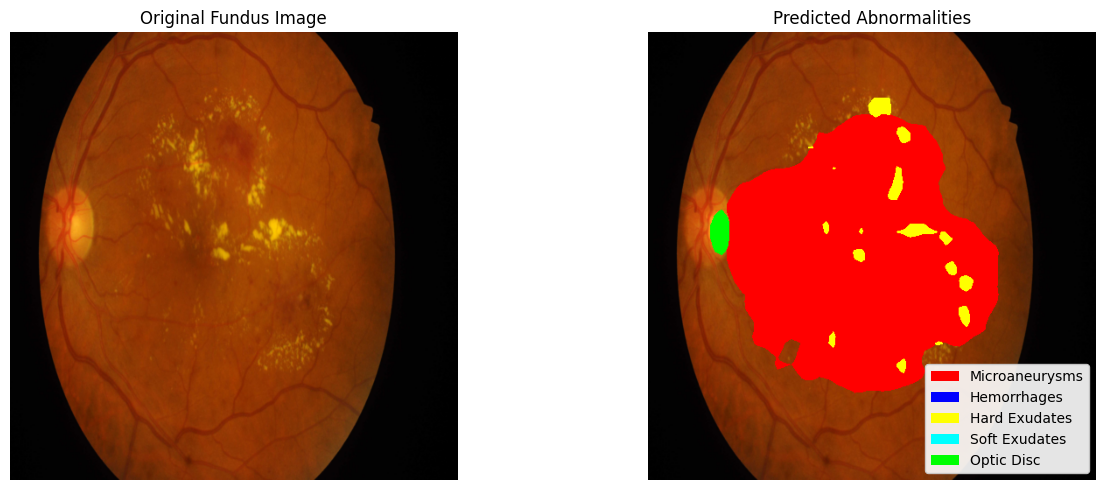

IDRiD_56.jpg {0: 198419, 1: 63619, 2: 44, 3: 29, 4: 33}


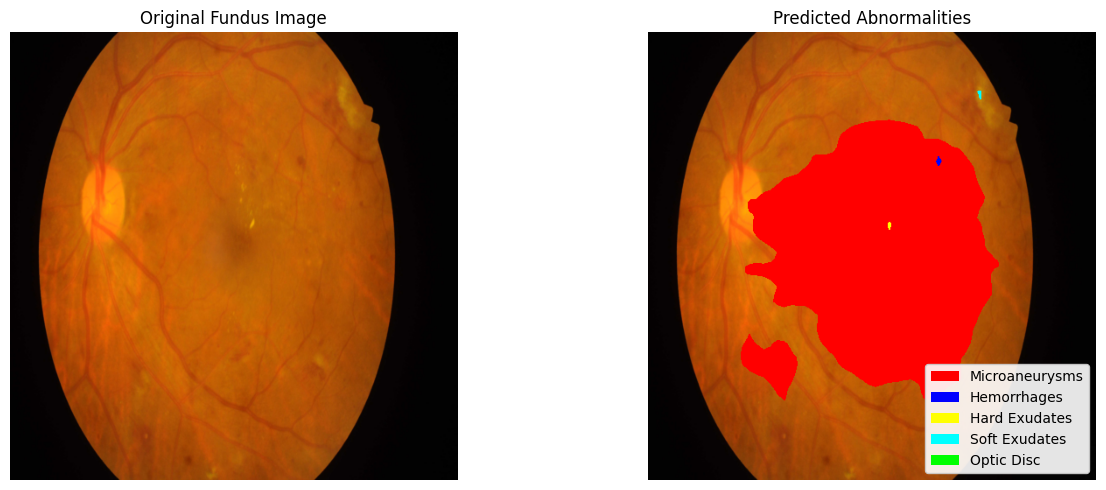

IDRiD_57.jpg {0: 220377, 1: 41767}


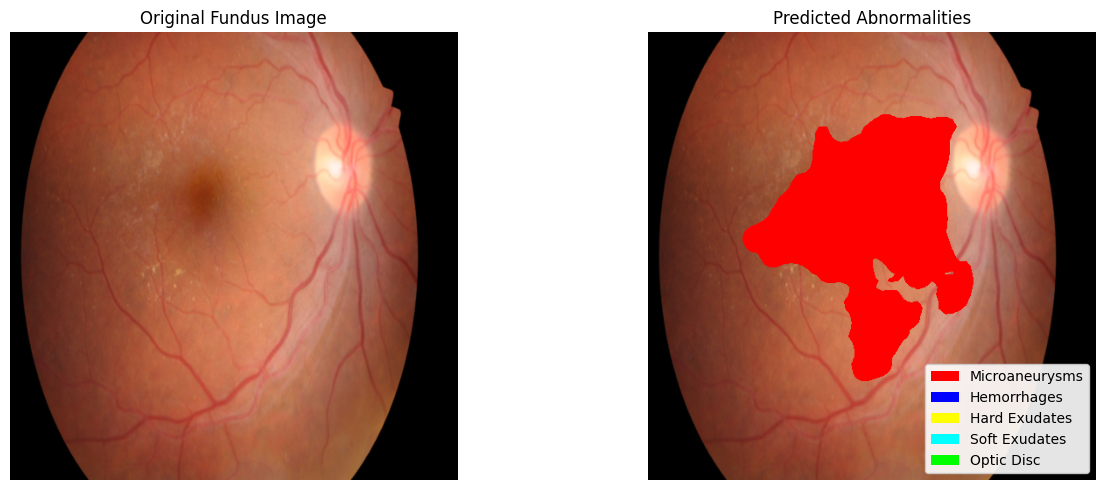

IDRiD_58.jpg {0: 198179, 1: 63963, 2: 2}


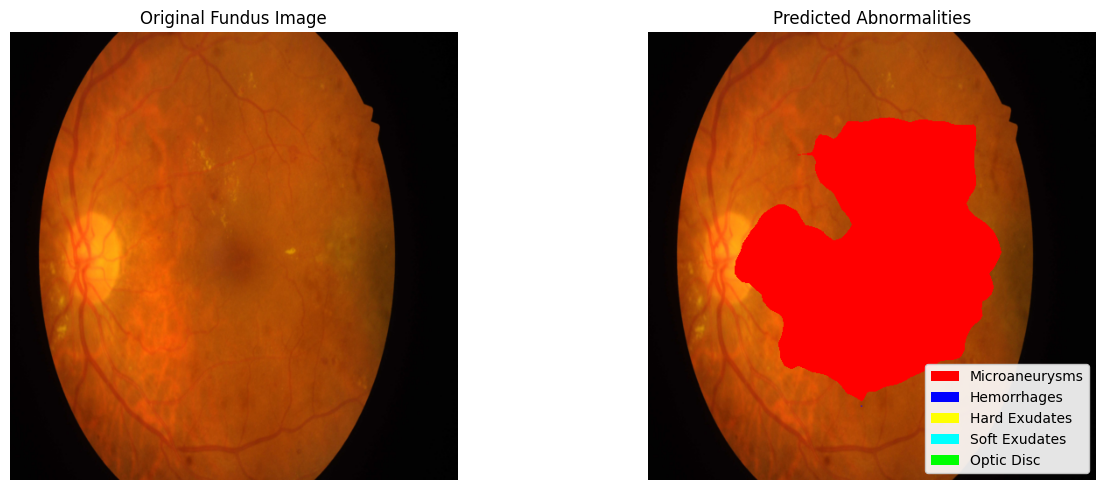

IDRiD_59.jpg {0: 200754, 1: 60435, 2: 334, 3: 291, 5: 330}


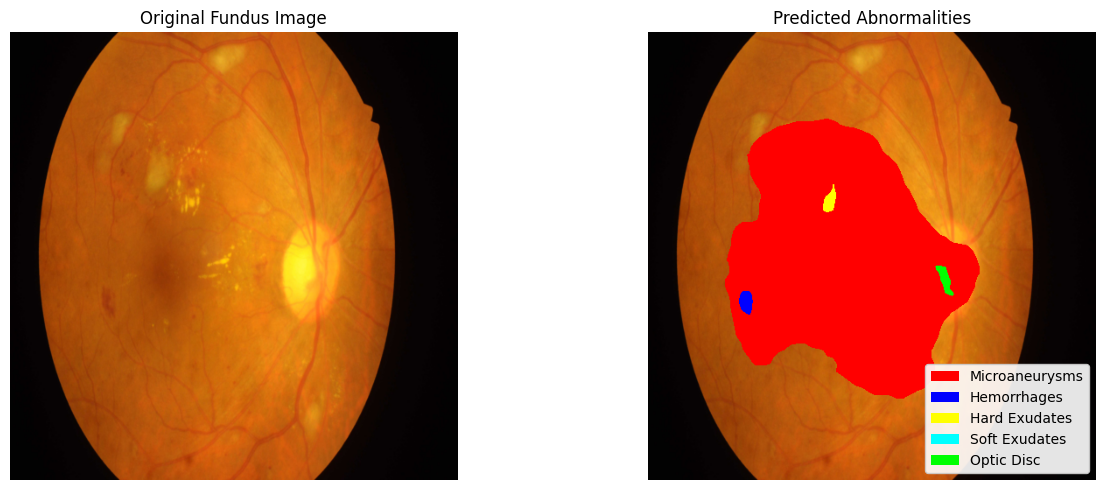

IDRiD_60.jpg {0: 199646, 1: 62155, 2: 95, 3: 248}


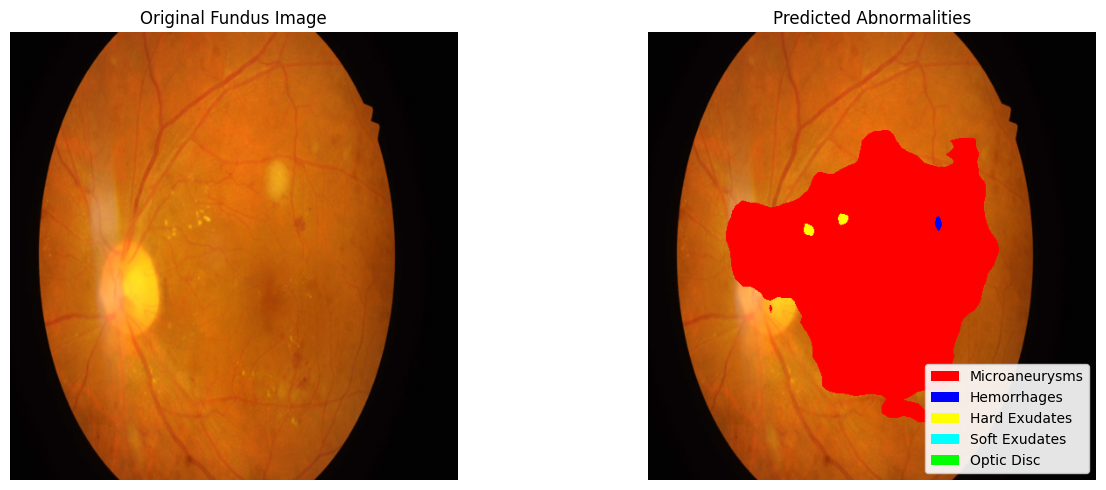

IDRiD_61.jpg {0: 195462, 1: 66474, 2: 30, 4: 178}


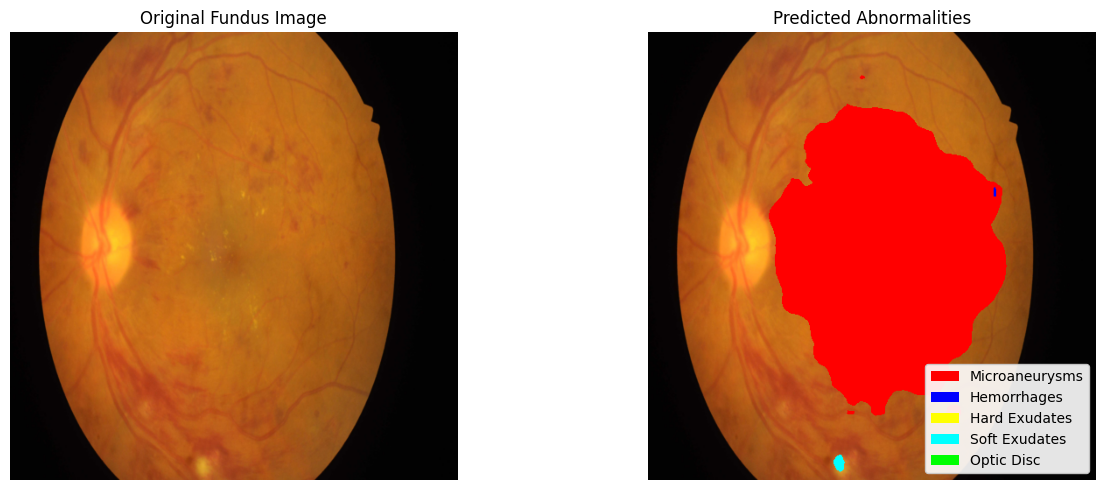

IDRiD_62.jpg {0: 201848, 1: 60073, 3: 223}


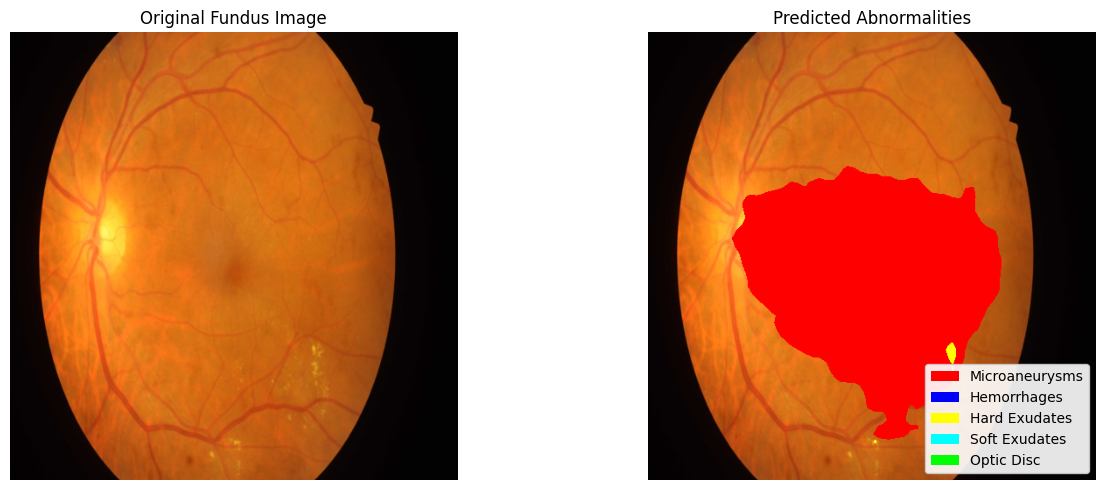

IDRiD_63.jpg {0: 203389, 1: 56536, 3: 14, 5: 2205}


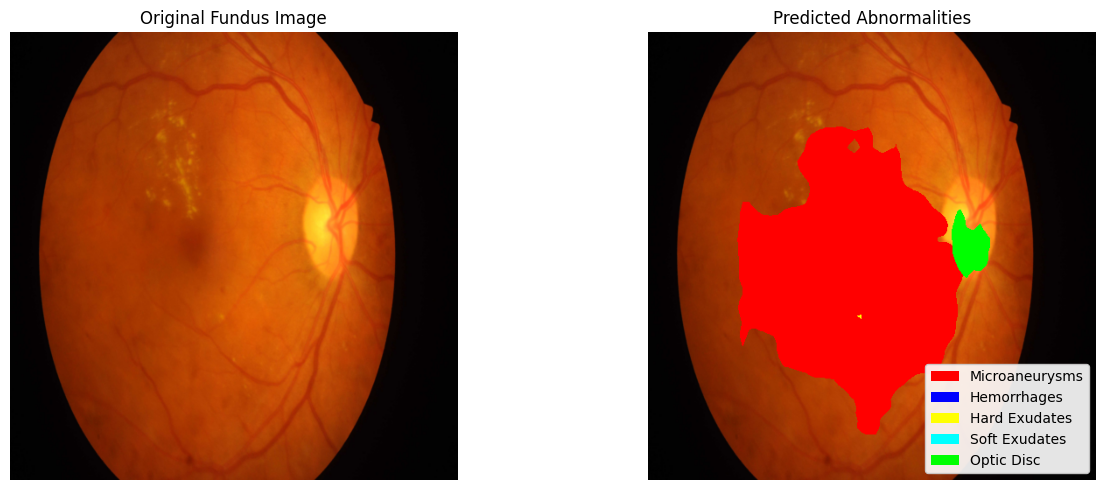

IDRiD_64.jpg {0: 213084, 1: 46317, 3: 84, 5: 2659}


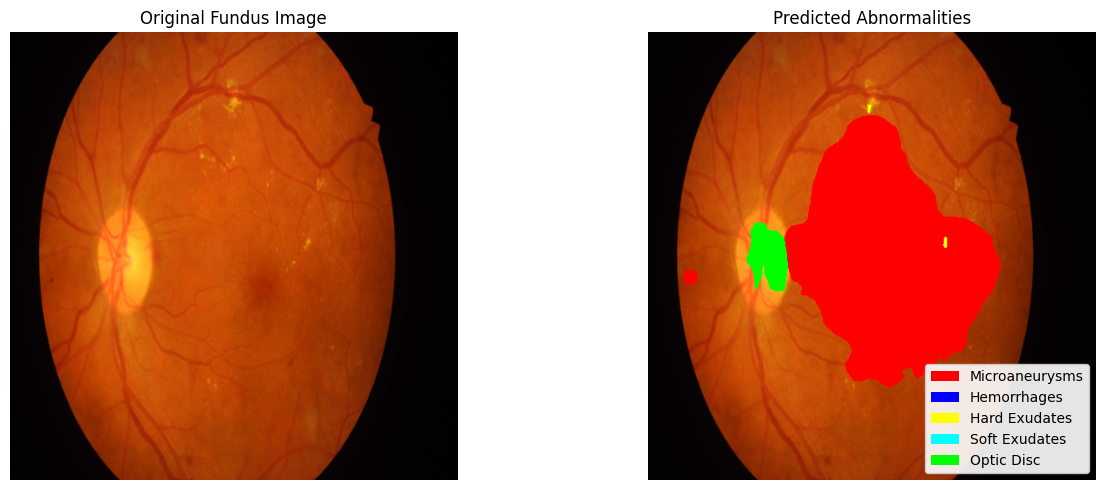

IDRiD_65.jpg {0: 211929, 1: 50179, 3: 36}


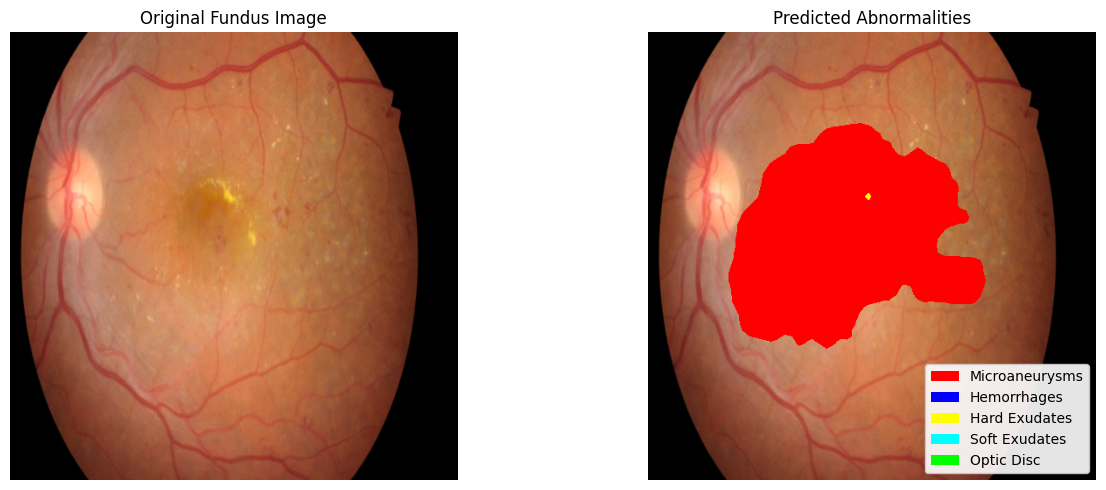

IDRiD_66.jpg {0: 183939, 1: 74864, 3: 3341}


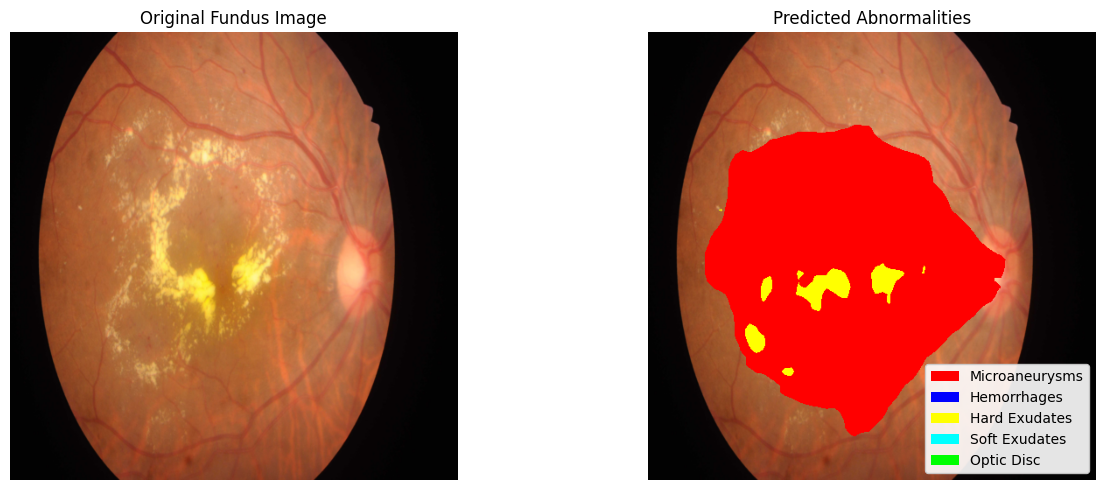

IDRiD_67.jpg {0: 168426, 1: 92307, 2: 1315, 4: 96}


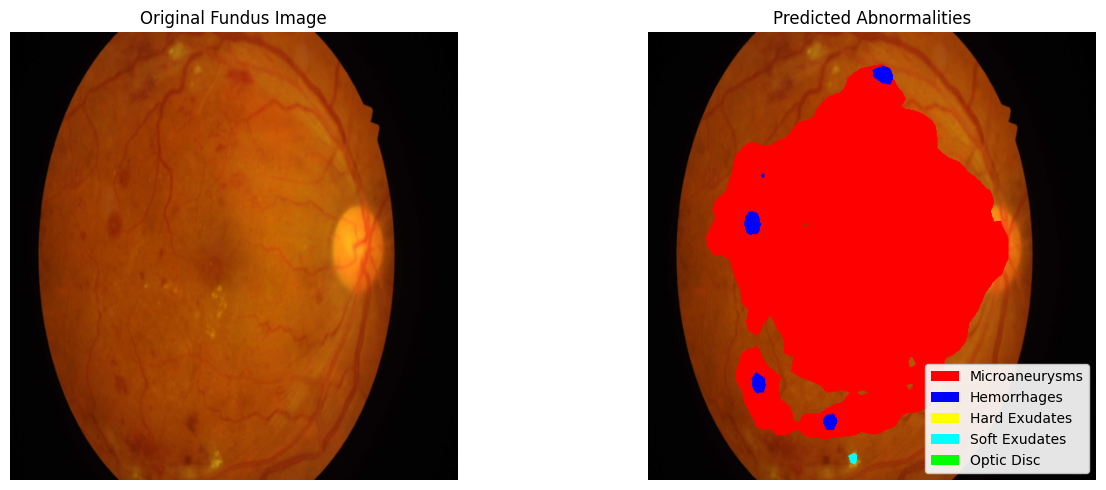

IDRiD_68.jpg {0: 188577, 1: 73098, 2: 458, 4: 11}


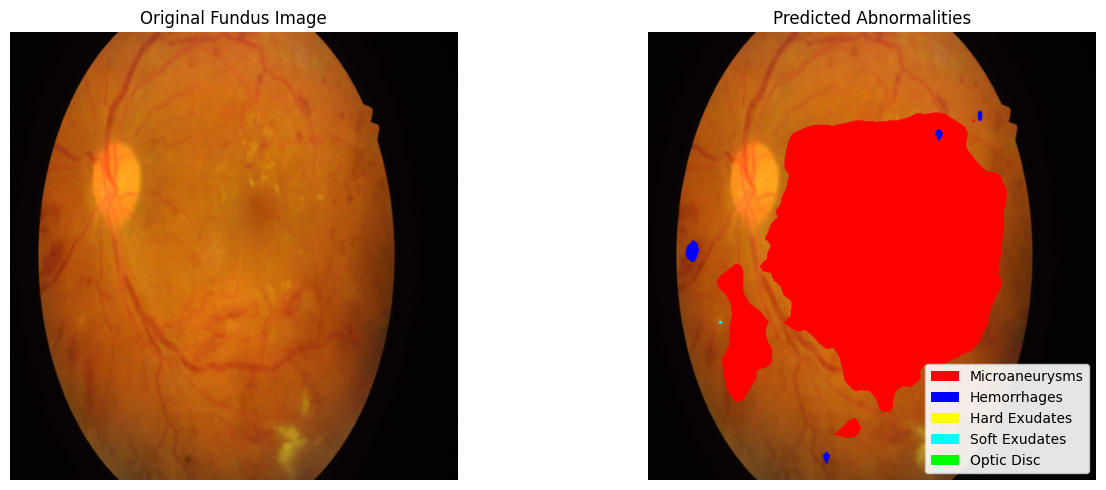

IDRiD_69.jpg {0: 188811, 1: 72420, 2: 298, 4: 615}


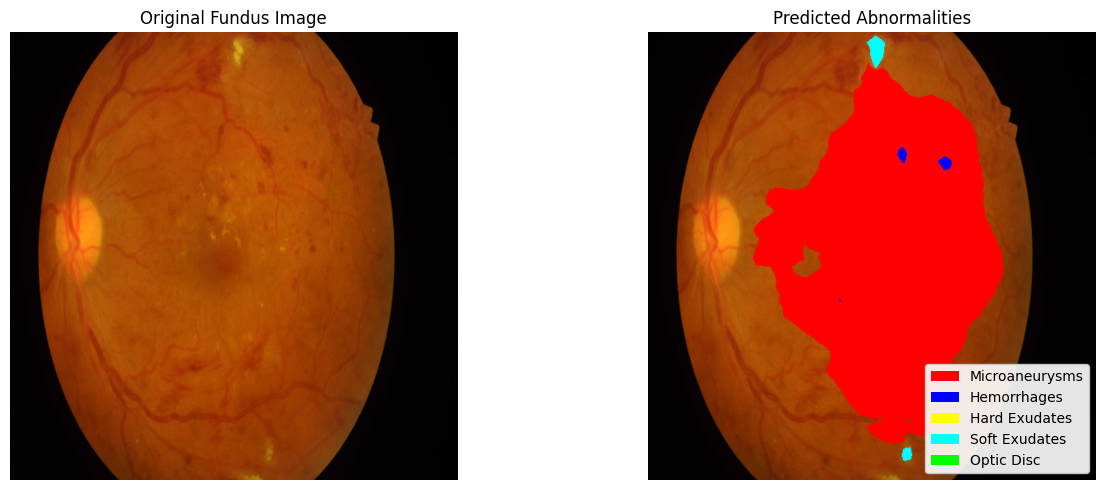

IDRiD_70.jpg {0: 209180, 1: 52964}


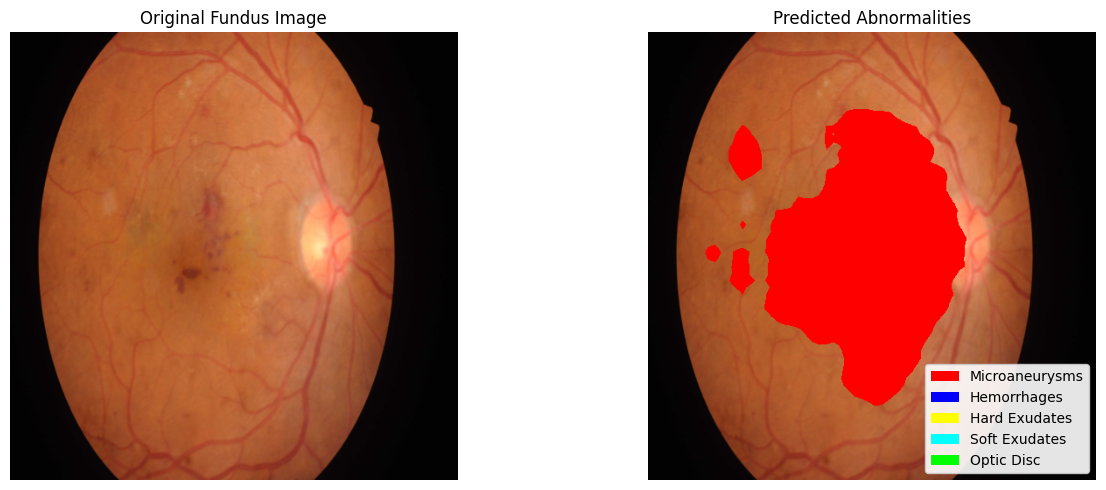

IDRiD_71.jpg {0: 189791, 1: 70311, 3: 1480, 5: 562}


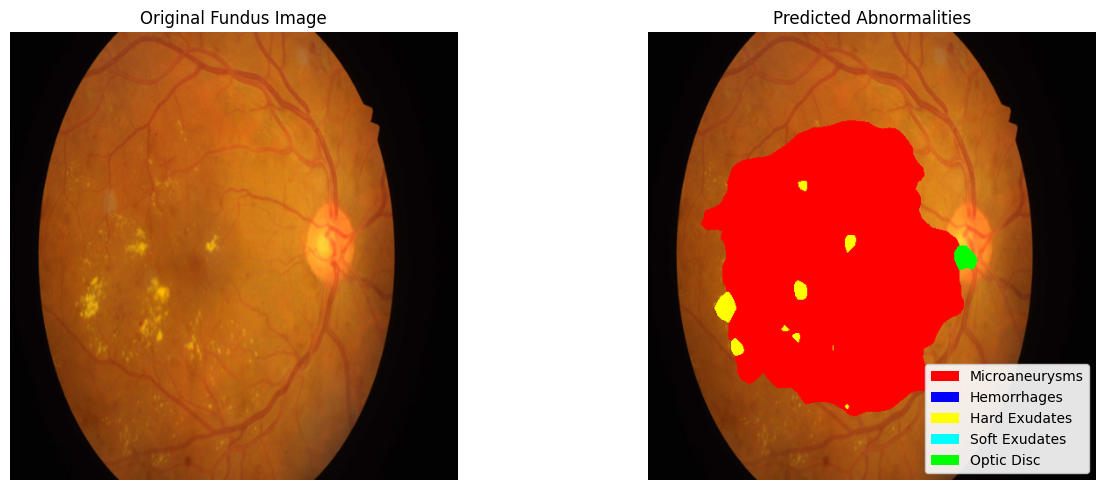

IDRiD_72.jpg {0: 211558, 1: 47511, 3: 2447, 5: 628}


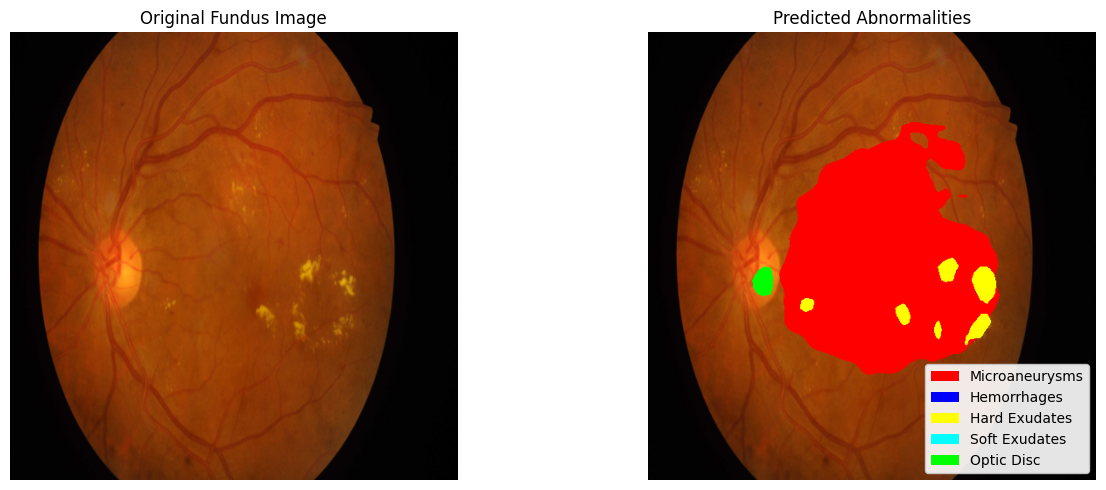

IDRiD_73.jpg {0: 221346, 1: 40507, 2: 184, 5: 107}


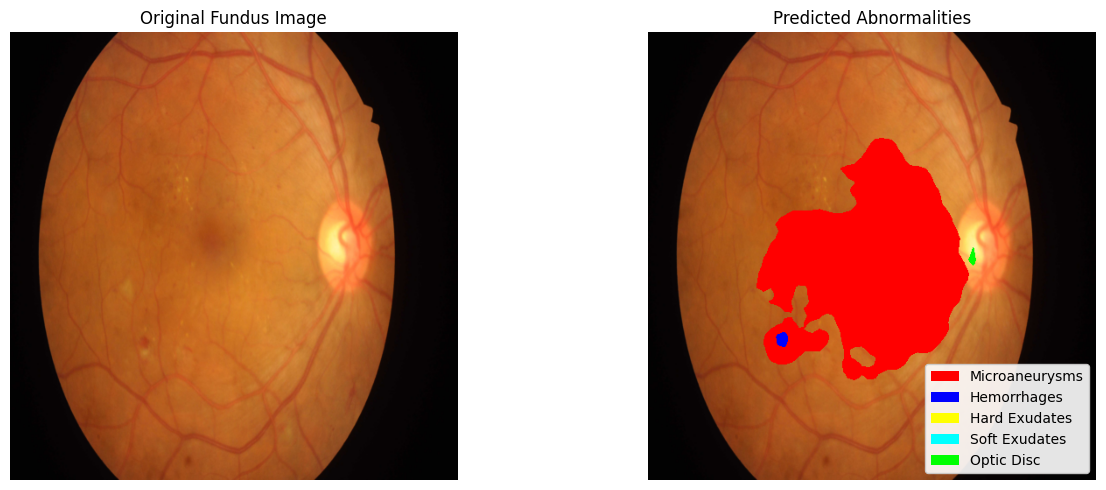

IDRiD_74.jpg {0: 204369, 1: 57505, 2: 160, 3: 110}


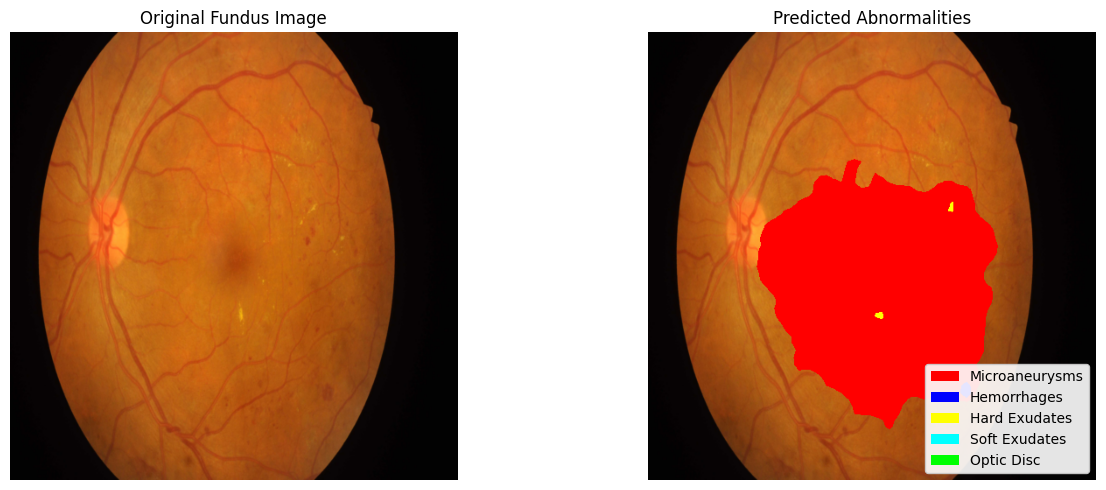

IDRiD_75.jpg {0: 220026, 1: 41841, 3: 62, 4: 160, 5: 55}


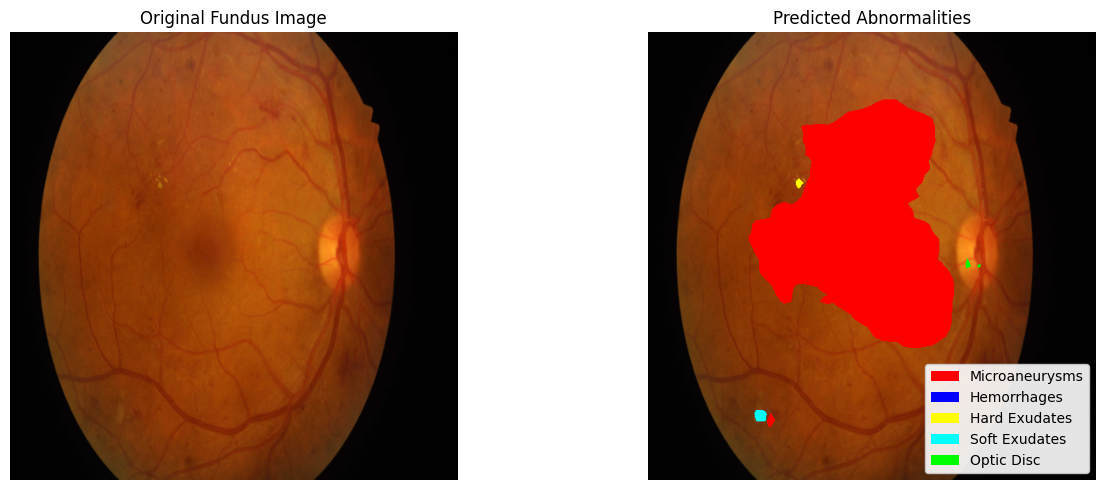

IDRiD_76.jpg {0: 205372, 1: 56293, 3: 467, 4: 12}


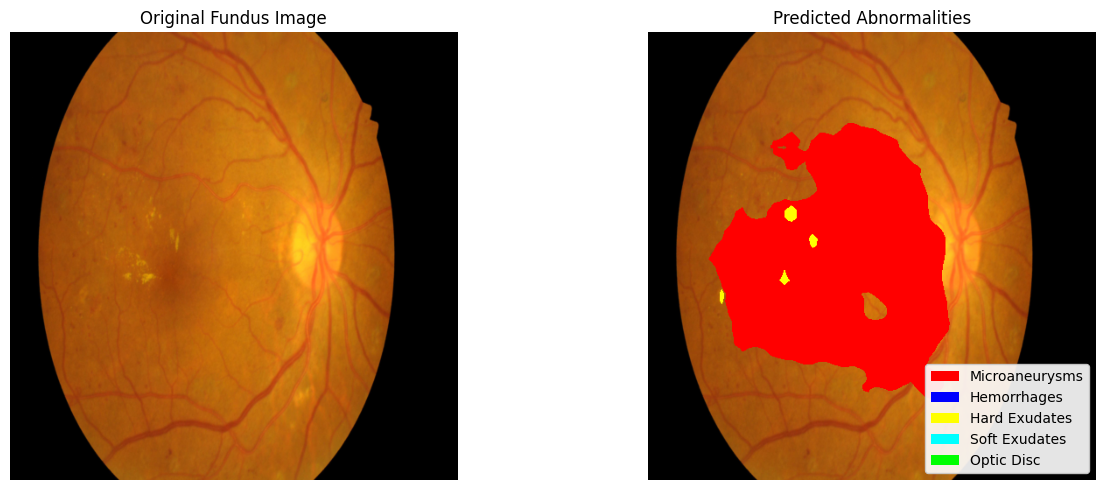

IDRiD_77.jpg {0: 210674, 1: 51362, 3: 108}


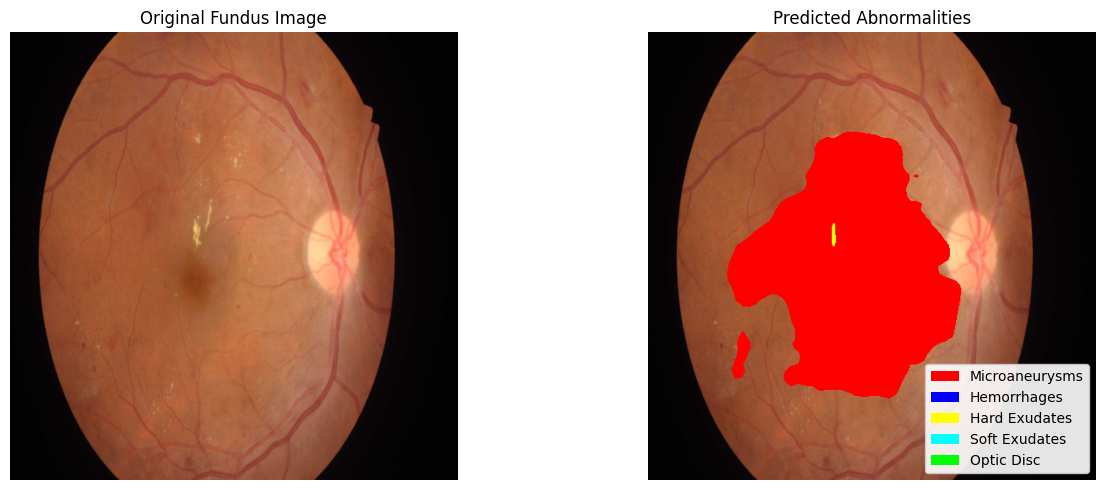

IDRiD_78.jpg {0: 215256, 1: 45926, 3: 309, 5: 653}


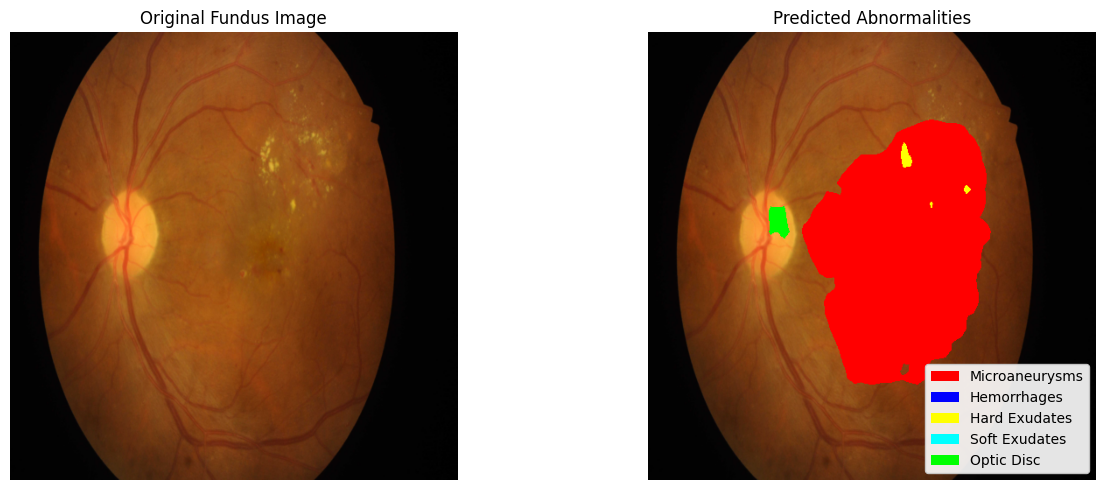

IDRiD_79.jpg {0: 187559, 1: 67766, 2: 47, 3: 6772}


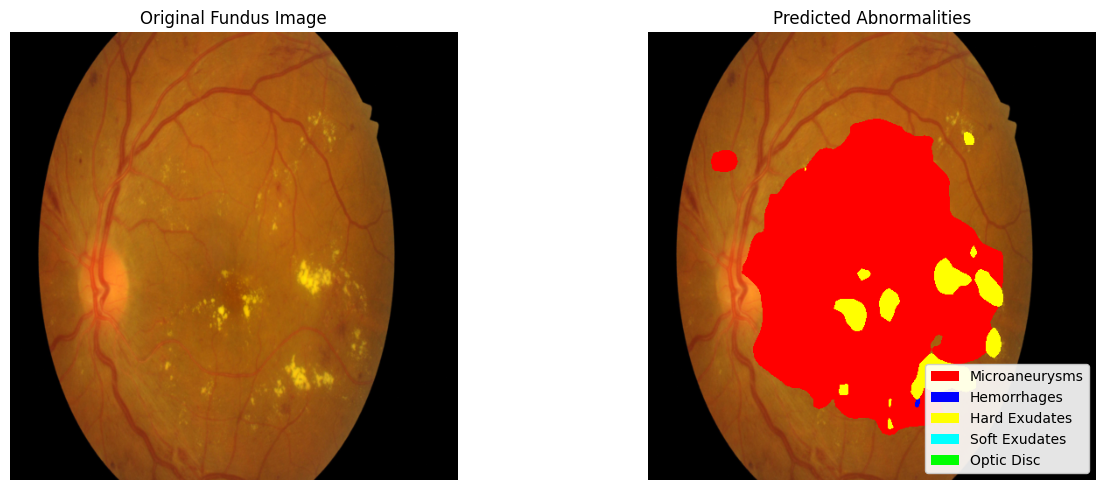

IDRiD_80.jpg {0: 227895, 1: 34249}


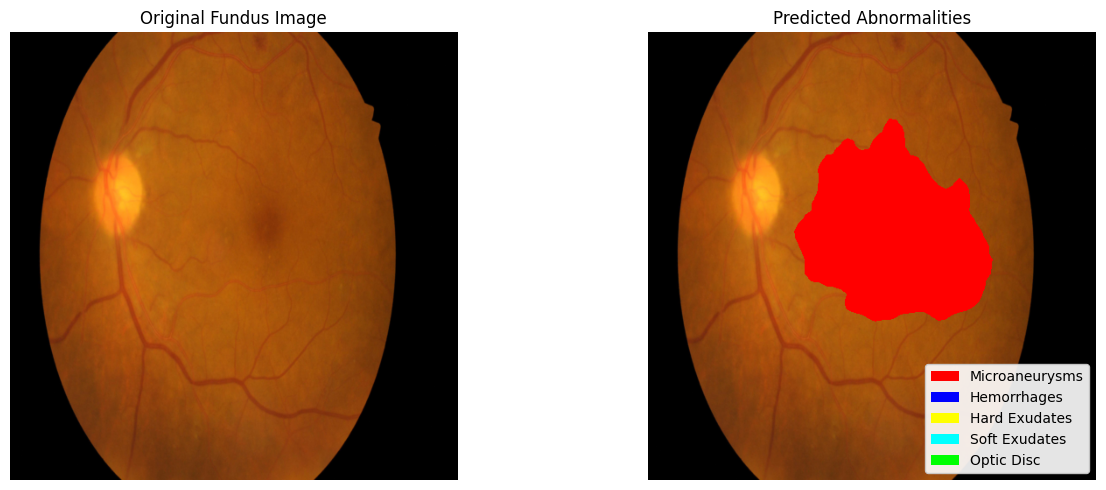

IDRiD_81.jpg {0: 190524, 1: 69462, 3: 1906, 4: 252}


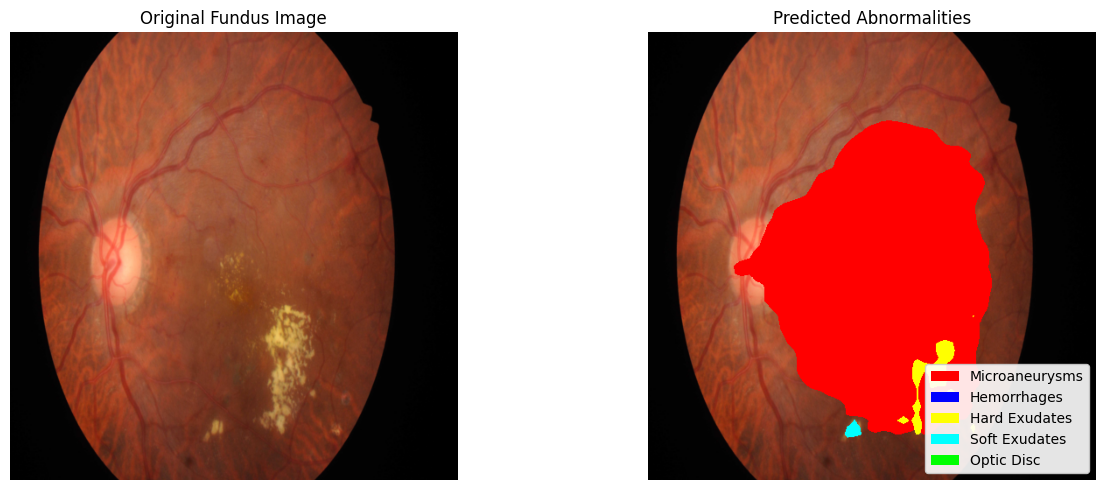

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from PIL import Image

from torchvision.models.segmentation import deeplabv3_resnet50

# =========================================================
# CONFIG
# =========================================================

NUM_CLASSES = 6
IMAGE_SIZE = 512

IDRID_ROOT = "/Users/akhilgattu/Desktop/VLM_project"          # CHANGE THIS
MODEL_PATH = "checkpoints/deeplabv3_idrid_epoch_030_finetune.pth"

# class_id : (name, RGB)
CLASS_INFO = {
    1: ("Microaneurysms", (255,   0,   0)),   # Red
    2: ("Hemorrhages",    (  0,   0, 255)),   # Blue
    3: ("Hard Exudates",  (255, 255,   0)),   # Yellow
    4: ("Soft Exudates",  (  0, 255, 255)),   # Cyan
    5: ("Optic Disc",     (  0, 255,   0)),   # Green
}

# =========================================================
# DEVICE
# =========================================================

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# =========================================================
# MODEL (NO AUX CLASSIFIER)
# =========================================================

model = deeplabv3_resnet50(
    weights=None,
    aux_loss=False        # IMPORTANT
)

# replace classifier for IDRiD
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, 1)

# =========================================================
# LOAD CHECKPOINT (STRIP aux_classifier)
# =========================================================

ckpt = torch.load(MODEL_PATH, map_location="cpu")

# handle common checkpoint formats
if "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
elif "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
else:
    state_dict = ckpt

clean_state = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")  # DDP safety
    if not k.startswith("aux_classifier"):
        clean_state[k] = v

missing, unexpected = model.load_state_dict(clean_state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.to(device)
model.eval()

# sanity check
for name, p in model.named_parameters():
    if "classifier.4.weight" in name:
        print("Classifier mean abs:", p.abs().mean().item())

# =========================================================
# TRANSFORMS (MATCH TRAINING)
# =========================================================

img_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor()
])


resize_only = T.Resize((IMAGE_SIZE, IMAGE_SIZE))

# =========================================================
# OVERLAY (SOLID COLORS — NO ALPHA)
# =========================================================

def overlay_mask(image, mask):
    overlay = image.copy()
    for cls, (_, color) in CLASS_INFO.items():
        ys, xs = np.where(mask == cls)
        if len(xs) > 0:
            overlay[ys, xs] = color
    return overlay

# =========================================================
# LEGEND
# =========================================================

def add_legend(ax):
    patches = [
        Patch(facecolor=np.array(color) / 255.0, label=name)
        for (_, (name, color)) in CLASS_INFO.items()
    ]
    ax.legend(
        handles=patches,
        loc="lower right",
        frameon=True,
        framealpha=0.9,
        fontsize=10
    )

# =========================================================
# VISUALIZATION LOOP
# =========================================================

test_img_dir = os.path.join(
    IDRID_ROOT,
    "A. Segmentation",
    "1. Original Images",
    "b. Testing Set"
)

image_files = sorted(os.listdir(test_img_dir))

for img_name in image_files:
    img_path = os.path.join(test_img_dir, img_name)

    # ---- load image ----
    original = Image.open(img_path).convert("RGB")
    original_resized = resize_only(original)
    original_np = np.array(original_resized)

    input_tensor = img_transform(original).unsqueeze(0).to(device)

    # ---- inference ----
    with torch.no_grad():
        logits = model(input_tensor)["out"]
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_mask = np.argmax(probs, axis=0)

        # suppress very low confidence pixels
        #pred_mask[probs.max(axis=0) < 0.4] = 0

    # ---- debug: prove segmentation exists ----
    unique, counts = np.unique(pred_mask, return_counts=True)
    print(img_name, dict(zip(unique.tolist(), counts.tolist())))

    overlay = overlay_mask(original_np, pred_mask)

    # ---- plot ----
    plt.figure(figsize=(14, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(original_np)
    ax1.set_title("Original Fundus Image")
    ax1.axis("off")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(overlay)
    ax2.set_title("Predicted Abnormalities")
    ax2.axis("off")

    add_legend(ax2)

    plt.tight_layout()
    plt.show()


In [27]:
unique, counts = np.unique(pred_mask, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(262144)}
